In [112]:
import torch
import numpy as np
from torch import Tensor
import pandas as pd
from pathlib import Path
from labproject.plotting import cm2inch, place_boxplot, place_violin

from matplotlib import rc_file
rc_file("../../matplotlibrc")

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from labproject.metrics.MMD_torch import *
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.c2st import *
from labproject.metrics.gaussian_squared_wasserstein import gaussian_squared_w2_distance

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt

from matplotlib.font_manager import fontManager

fontManager.addfont(Path(".").absolute().parent.parent / "fonts/arial.ttf")
matplotlib.rc("font", **{"family": "sans-serif", "sans-serif": "Arial"})

In [113]:
from pathlib import Path

In [114]:
cxr1 = torch.load('../../data/cxr/encs_real.pt')
cxr2 = torch.load('../../data/cxr/encs_fake_pggan.pt')
cxr3 = torch.load('../../data/cxr/encs_fake_stable_diffusion.pt')
ddm1 = torch.load('../../data/ddm/real_data.pt')
ddm2 = torch.load('../../data/ddm/generated_data.pt')
ddm3 = torch.load('../../data/ddm/gaussian_data.pt')

In [115]:
ddm1.shape

torch.Size([1023, 1])

In [116]:
from typing import Iterable

class Metric:
    def __init__(self, name: str, func: callable, **kwargs):
        self.name = name
        self.func = func
        self.kwargs = kwargs

    def __call__(self, x: Tensor, y: Tensor) -> Tensor:
        return self.func(x, y, **self.kwargs)
    

class DistComp:
    def __init__(self, dataset1: Tensor, dataset2: Tensor, metric: Metric, 
                 n_perms: int = 100, perm_size=1000, descr=""):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.metric = metric
        self.n_perms = n_perms
        self.perm_size = perm_size
        self.descr = descr

        columns = [metric.name]
        self.results_df = pd.DataFrame(np.nan, index=range(self.n_perms), columns=columns)

    def run_experiment(self):
        # for i in range(self.n_perms):
        #     self.results_df.loc[i, self.metric.name] = np.random.normal()
        for i in range(self.n_perms):
            dataset2_perm = self.dataset2[torch.randperm(len(self.dataset2))[:self.perm_size]]
            dataset1_perm = self.dataset1[torch.randperm(len(self.dataset1))[:self.perm_size]]
            
            metric = self.metric(dataset1_perm, dataset2_perm)
            
            
            
            if isinstance(metric, torch.Tensor):
                metric = metric.item()
            self.results_df.loc[i, self.metric.name] = metric
        assert not np.any(np.isnan(self.results_df.values))
    
    def reformat_df(self, data):
        """
        reformat the results_df to work with seaborn plot expectations.
        """
        metric = [column_name for _, row in data.iterrows() for column_name, _ in row.items()]
        split_ind = [i for i, _ in data.iterrows() for _ in range(len(data.columns))]
        distance = [value for _, row in data.iterrows() for _, value in row.items()]

        return pd.DataFrame({"metric": metric, "distance": distance, "split_ind": split_ind})
    
    def __repr__(self):
        return f"{self.__class__.__name__}\nDescription:{self.descr}"

In [121]:
datasets = [
    (ddm1, ddm1),
     (ddm1, ddm2),
#     (ddm2, ddm2),
    (ddm1, ddm3),
    (ddm2, ddm3),
#     (ddm3, ddm3),
    (cxr1, cxr1),
    (cxr1, cxr2),
#     (cxr2, cxr2),
    (cxr1, cxr3),
    (cxr2, cxr3),
#     (cxr3, cxr3),
]

dataset_list = ["ddm", "cxr"]
comparisons_lists = {"ddm": ["real vs real",
                             "real vs DDM", 
                             #"DDM vs DDM", 
                             "real vs Gaussian", 
                             "DDM vs Gaussian",
                             #"Gaussian vs Gaussian"
                             ], 
                     "cxr": ["real vs real", 
                             "real vs PGGAN", 
                             #"PGGAN vs PGGAN", 
                             "real vs Stable Diffusion", 
                             "PGGAN vs Stable Diffusion", 
                             #"Stable Diffusion vs Stable Diffusion"
                             ]}

descr_list = ['ddm - real vs real',
              'ddm - real vs DDM',
              # 'ddm - DDM vs DDM',
              'ddm - real vs Gaussian',
              'ddm - DDM vs Gaussian',
              # 'ddm - Gaussian vs Gaussian',
              'cxr - real vs real',
              'cxr - real vs PGGAN',
              # 'cxr - PGGAN vs PGGAN',
              'cxr - real vs Stable Diffusion',
              'cxr - PGGAN vs Stable Diffusion',
              # 'cxr - Stable Diffusion vs Stable Diffusion'
               ]

datasets_dict = {desc: dataset for desc, dataset in zip(descr_list, datasets)}

metrics = [
    Metric('SW', 
           sliced_wasserstein_distance),
    Metric('C2ST', 
           c2st_nn,
           ),
    Metric('MMD', 
           compute_rbf_mmd, bandwidth=.5),
    Metric("FID", gaussian_squared_w2_distance)
]
metrics_names = [metric.name for metric in metrics]

n_metrics = len(metrics)
n_modalities = len(dataset_list)

# assuming same number of comparisons per dataset
n_comparisons = len(datasets) // n_modalities
n_perms=10


In [122]:
experiments = np.zeros([n_metrics, n_modalities, n_comparisons, n_perms])
for i, metric in enumerate(metrics):
    for j, dataset_id in enumerate(dataset_list):
           print(i, j, metric, dataset_id)
           for k, comparison in enumerate(comparisons_lists[dataset_id]):
               # print(i, j, k, metric, dataset_id, comparison)
               descr = f"{dataset_id} - {comparison}"
               dataset =  datasets_dict[descr]
               dataset = list(dataset)
               dataset[0] = torch.tensor(dataset[0], dtype=torch.float32)
               dataset[1] = torch.tensor(dataset[1], dtype=torch.float32)
               if "ddm" in descr:
                     if metric.name == "MMD":
                        metric.kwargs = {"bandwidth": 0.5}
                     perm_size = 300 
               else:
                     if metric.name == "MMD":
                        metric.kwargs = {"bandwidth": 50.}
                     perm_size = 1000
                     
            #    if "ddm" not in descr:
            #          continue
              
               exp = DistComp(dataset[0], dataset[1], metric, n_perms=n_perms, perm_size=perm_size, descr=descr)
               exp.run_experiment()
               experiments[i, j, k, :] = exp.results_df.to_numpy().flatten()

0 0 <__main__.Metric object at 0x7fcadecf2b80> ddm
0 1 <__main__.Metric object at 0x7fcadecf2b80> cxr
1 0 <__main__.Metric object at 0x7fcae1075ca0> ddm
1 1 <__main__.Metric object at 0x7fcae1075ca0> cxr
2 0 <__main__.Metric object at 0x7fcae2cd8460> ddm
2 1 <__main__.Metric object at 0x7fcae2cd8460> cxr
3 0 <__main__.Metric object at 0x7fcae24525b0> ddm
3 1 <__main__.Metric object at 0x7fcae24525b0> cxr


In [123]:
def generate_palette(hex_color, n_colors=5, saturation="light"):
    if saturation == "light":
        palette = sns.light_palette(hex_color, n_colors=n_colors, as_cmap=False)
    elif saturation == "dark":
        palette = sns.dark_palette(hex_color, n_colors=n_colors, as_cmap=False)
    return palette

color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}

In [124]:
from labproject.plotting import tiled_ticks, get_lims, rm_spines

In [125]:
X = tiled_ticks(0, 2, n_major_ticks=1, n_minor_ticks=n_comparisons, offset=0.175)

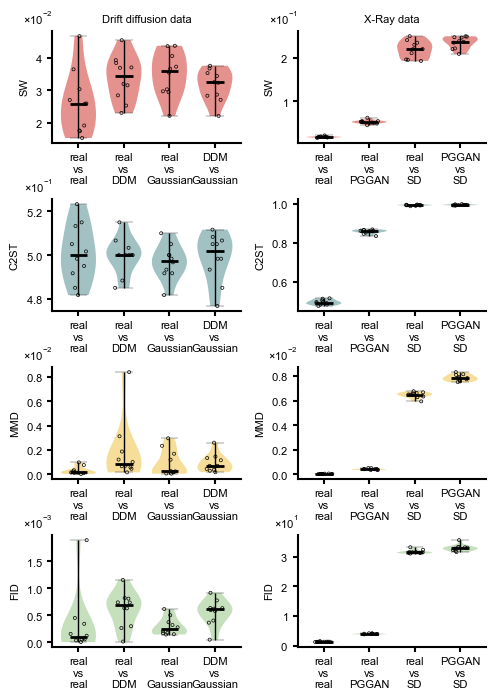

In [130]:

fig, axes = plt.subplots(4, 2, figsize=[5.6, 8])

import matplotlib.ticker as ticker

# Set the formatter
formatter = ticker.ScalarFormatter(useMathText=True) # Use mathematical text for scientific notation
formatter.set_scientific(True) # Enable scientific notation
formatter.set_powerlimits((-1,1)) # This will force scientific notation

comparisons_lists_xticks = {"ddm": ["real vs real", "real vs DDM", "DDM vs DDM", "real vs Gaussian", "DDM vs Gaussian", "Gaussian vs Gaussian"], 
                     "cxr": ["real vs real", "real vs PGGAN", "PGGAN vs PGGAN", "real vs Stable Diffusion", "PGGAN vs Stable Diffusion", "Stable Diffusion vs Stable Diffusion"]}

def type_akronym(name):
    akronyms = {"Stable Diffusion": "SD"}
    if name in akronyms:
        return akronyms[name]
    return name

datasets_long_name = {"ddm": "Drift diffusion data", 
                      "cxr": "X-Ray data"}

for i in range(n_metrics):
    body_colors = generate_palette(color_dict[metrics_names[i]], n_colors=n_comparisons)
    
    for j, dataset_id in enumerate(dataset_list):
       ax = axes[i, j]
       for k, comparison in enumerate(comparisons_lists[dataset_id]):
            x, Y = X[0][k], experiments[i, j, k]
            place_violin(ax, x, Y, 
                         scatter_face_color="none",
                        scatter_edge_color="k",
                        scatter_lw=0.5,
                        scatter_radius=5,
                        scatter_alpha=1,
                        scatter_width=0.5,
                        scatter=True,
                        scatter_zorder=3,
                        width=0.09, 
                        median_color='k', #color_dict[metrics_names[i]],
                        median_bar_length=0.5, 
                        median_lw=2, 
                        whisker_color='k', #color_dict[metrics_names[i]],
                        whisker_alpha=1, 
                        whisker_lw=1,
                        median_alpha=1,
                        #    body_face_color=body_colors[k])
                        body_face_color=color_dict[metrics_names[i]],
                        body_edge_color="none",
                        body_alpha=0.5)

# cosmetics
ylims = [get_lims(x, 0.1) for x in experiments]
for row, _axes in enumerate(axes):
    for column, ax in enumerate(_axes):
        
        # ax.set_ylim(ylims[row])

        # # in first column, label the y axis
        # if column == 0:
        ax.set_ylabel(metrics_names[row])
        # # in second column, remove the y axis
        # if column == 1:
        #     rm_spines(ax,
        #              spines=("left",),
        #              visible=False,
        #              rm_xticks=True,
        #              rm_yticks=True)

        ax.yaxis.set_major_formatter(formatter)
        # Adjust the position of the exponent (scientific notation)
        # Move the offset text to the top
        ax.yaxis.get_offset_text().set_position((0, 10))
        # Optionally, adjust the alignment if needed
        ax.yaxis.get_offset_text().set_verticalalignment('bottom')
        ax.yaxis.get_offset_text().set_horizontalalignment('right')

        if row == 0:
            ax.set_title(datasets_long_name[dataset_list[column]])

        
        
        comparison_name = comparisons_lists[dataset_list[column]]
        xticklabel = [[type_akronym(_c) for _c in c.split(" vs ")] for c in comparison_name]
        xticklabel = ["\nvs\n".join(xtl) for xtl in xticklabel] 
        ax.set_xticks(X[0], xticklabel, rotation=0)
        ax.patch.set_alpha(0)

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.savefig("distances_violin.pdf", bbox_inches="tight")



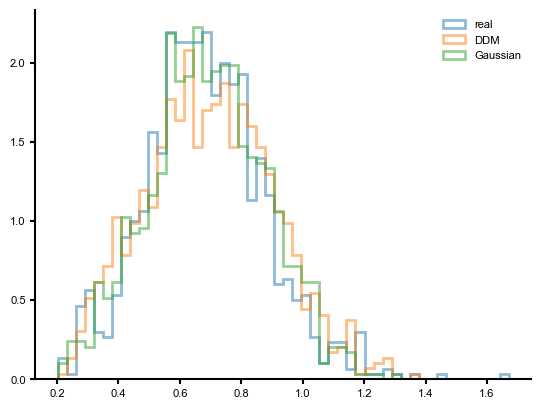

In [120]:
n, bins, _ = plt.hist(ddm1.flatten(), bins=50, alpha=0.5, label='real', histtype='step', lw=2, density=True)
n, bins, _ = plt.hist(ddm2.flatten(), bins=bins, alpha=0.5, label='DDM', histtype='step', lw=2, density=True)
n, bins, _ = plt.hist(ddm3.flatten(), bins=bins, alpha=0.5, label='Gaussian', histtype='step', lw=2, density=True)

plt.legend(loc='upper right')